# Wait for input Agent

Waiting for human input is a common HIL interaction, allowing the agent to ask clarifying questions and await input before proceeding.

In [1]:
import boto3
import json
import logging

from langchain_aws import ChatBedrock
from langchain_core.output_parsers import StrOutputParser

boto3.set_stream_logger('', logging.ERROR)

# Initialize AWS Bedrock client
bedrock_client = boto3.client(
    service_name='bedrock-runtime'
    ,region_name='ap-southeast-2'
)

llm = ChatBedrock(
    client=bedrock_client,
    model_id="amazon.nova-pro-v1:0",  
    model_kwargs={
        "temperature": 0.3,  # Same temperature as original
        "maxTokenCount": 1000
    }
)

Load the Travily API keys:

In [2]:
%load_ext dotenv
%dotenv ../../.env

Ask from the user using Pydantic data model

In [3]:
from pydantic import BaseModel

class UserInput(BaseModel):
    user_input: str

List of tools for the agent:

In [4]:
from langchain_community.tools import TavilySearchResults

tavily_search = TavilySearchResults(
    max_results=2
)

/var/folders/8w/ytv2_9yd0nld4gbqjwbs4yw40000gn/T/ipykernel_35351/878479195.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_search = TavilySearchResults(


In [5]:
tools = [
    tavily_search
    , UserInput
]

Bind to the LLM

In [6]:
llm_with_tools = llm.bind_tools(tools)

Create the Graph state:

In [7]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

class AgentState(TypedDict):
    messages: Annotated[list, add_messages]

Build the graph

In [8]:
from langgraph.graph import StateGraph, END

graph_builder = StateGraph(AgentState)

def agent_node (state: AgentState):
    return { "messages":[llm_with_tools.invoke(state["messages"])] }

graph_builder.add_node("agent", agent_node)

Create and add tool node

In [9]:
from langgraph.prebuilt import ToolNode

tool_node = ToolNode(tools=[tavily_search])
graph_builder.add_node("tool", tool_node)

Create a node which inturrpt the execution for the user

In [10]:
def ask_user_node (state: AgentState):
    pass

graph_builder.add_node("ask_user", ask_user_node)

Need to add the contional node which will intrupt the exection and ask user input to proceed to the tool node.

In [11]:
def routing_condition (state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls:
        return END
    elif last_message.tool_calls[0]["name"] == "UserInput":
        return "ask_user"
    else:
        return "tool"

# add conditional edges
graph_builder.add_conditional_edges("agent"
    , routing_condition
    , {END: END, "ask_user": "ask_user", "tool":"tool"}
)

Add the edges

In [12]:
graph_builder.add_edge("tool", "agent")
graph_builder.add_edge("ask_user", "agent")
graph_builder.set_entry_point("agent")

Set the checkpoint for conversation state. Compile the graph.

In [13]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

graph = graph_builder.compile(
    checkpointer=memory
    , interrupt_before=["ask_user"]
)

check the graph

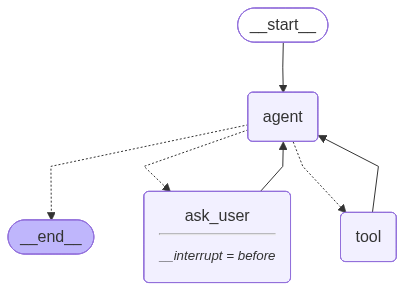

In [14]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

Let us check the functionality

In [15]:
cfg_user_1 = {"configurable": {"thread_id": "1"}}

In [16]:
events = graph.stream(
    {"messages": [("user", "What is the weather?")]}
    , cfg_user_1
    , stream_mode="values"
)

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the weather?
================================== Ai Message ==================================

[{'type': 'text', 'text': '<thinking> To determine the current weather, I need to know the location. I should ask the user for the location first. </thinking>\n'}, {'type': 'tool_use', 'name': 'UserInput', 'input': {'user_input': 'Please provide the location for which you want to know the weather.'}, 'id': 'tooluse_6oh-d9KpQ0ybqQU7G0ukAg'}]
Tool Calls:
  UserInput (tooluse_6oh-d9KpQ0ybqQU7G0ukAg)
 Call ID: tooluse_6oh-d9KpQ0ybqQU7G0ukAg
  Args:
    user_input: Please provide the location for which you want to know the weather.


Inspect the state of the grph and find how to provide the user input.

In [17]:
snapshot = graph.get_state(cfg_user_1)
print("Next node: ", snapshot.next)

Next node:  ('ask_user',)


Now update the message as a user

In [20]:
from langchain_core.messages import ToolMessage

# Get the tool call ID
tool_call_id = snapshot.values["messages"][-1].tool_calls[0]["id"]

user_response = ToolMessage(
    content="For Sydney"
    , tool_call_id=tool_call_id
)

# update the graph
graph.update_state(cfg_user_1, {"messages" : [user_response]}, as_node="ask_user")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f086d38-e33e-6746-8002-1dcb5d832a4a'}}

Continue the execution

In [22]:
events = graph.stream(
    None # update the graph
    , cfg_user_1
    , stream_mode="values"
)

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================= Tool Message =================================

For Sydney
================================== Ai Message ==================================

[{'type': 'text', 'text': '<thinking> Now that I have the location, I can use the `tavily_search_results_json` tool to get the current weather for Sydney. </thinking> '}, {'type': 'tool_use', 'name': 'tavily_search_results_json', 'input': {'query': 'current weather in Sydney'}, 'id': 'tooluse_H0Kf6dr0SZaFaicyrniJkQ'}]
Tool Calls:
  tavily_search_results_json (tooluse_H0Kf6dr0SZaFaicyrniJkQ)
 Call ID: tooluse_H0Kf6dr0SZaFaicyrniJkQ
  Args:
    query: current weather in Sydney
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Sydney weather in September 2025 | New South Wales", "url": "https://www.weather2travel.com/new-south-wales/sydney/september/", "content": "Browse the sunrise and sunset times for Sydney in September 2025. Select a mon